In [1]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import numpy as np

import json

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
CLIENT_ID = ""

CLIENT_SECRET = ""

In [3]:
token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
cache_token = token.get_access_token()

sp = spotipy.Spotify(cache_token)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  


In [4]:
#dictionary holding our three playlists' information, obviously editable by users later on 
pl_dict = {
    "United States Top 50" : ("spotifycharts", "37i9dQZEVXbLRQDuF5jeBp"),
    "United Kingdom Top 50" : ("spotifycharts", "37i9dQZEVXbLnolsZ8PSNw"),
    "Global Top 50" : ("spotifycharts", "37i9dQZEVXbMDoHDwVN2tF"),
    #"United States Viral 50" : ("spotifycharts", "37i9dQZEVXbKuaTI1Z1Afx"),
    #"United Kingdom Viral 50" : ("spotifycharts", "37i9dQZEVXbL3DLHfQeDmV"),
    #"Global Viral 50" : ("spotifycharts", "37i9dQZEVXbLiRSasKsNU9")
}

#the features of each track that we want to obtain
track_features = ['artist', 'track', 'album', 'id', 'danceability', 'energy', 'key',
               'loudness', 'mode', 'speechiness', 'instrumentalness', 'tempo', 'liveness', 'duration_ms']

def playlist(username, id_):
    #create a dataframe to store all our tracks
    df = pd.DataFrame(columns=track_features)
    
    #call the API to return a playlist (in our case, top 50 charts)
    playlist = sp.user_playlist_tracks(username, id_)
    
    #as shown above, we need to extract the information from items
    tracks = playlist["items"]
    
    for track in tracks:
        features = {}
        
        #navigating through the output from the spotify API and gathering categorical data for each track
        features['track'] = track['track']['name']
        features['album'] = track['track']['album']['name']
        features['artist'] = track['track']['album']['artists'][0]['name']
        features['id'] = track['track']['id']
        
        #we want audio (mostly numerical) data for each track
        audio = sp.audio_features(features['id'])[0]
        #the audio features of each track
        audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                          'instrumentalness', 'tempo', 'liveness', 'duration_ms']
        
        for feature in audio_features:
            features[feature] = audio[feature]
        
        #concat each track's dataframe with the overall playlist dataframe
        temp_df = pd.DataFrame(features, index=[0])
        df = pd.concat([df, temp_df], ignore_index=True)
    
    return df  


def playlists(playlist_dictionary):
    output = pd.DataFrame(columns=track_features)
    
    for (k, v) in playlist_dictionary.items():
        df = playlist(v[0], v[1])
        
        output = pd.concat([output, df], ignore_index=True)
    
    return output

In [5]:
all_tracks = playlists(pl_dict)
all_tracks = all_tracks.drop_duplicates(subset='track', keep='first')

top5_artists = all_tracks['artist'].value_counts()[:5]

In [6]:
all_tracks

,artist,track,album,id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,tempo,liveness,duration_ms
0,Cardi B,WAP (feat. Megan Thee Stallion),WAP (feat. Megan Thee Stallion),4Oun2ylbjFKMPTiaSbbCih,0.935,0.454,1,-7.509,1,0.3750,0,133.073,0.0824,187541
1,Internet Money,"Lemonade (feat. Gunna, Don Toliver & NAV)",B4 The Storm,7hxHWCCAIIxFLCzvDgnQHX,0.800,0.658,1,-6.142,0,0.0790,0,140.042,0.1110,195429
2,24kGoldn,Mood (feat. Iann Dior),Mood (feat. Iann Dior),3tjFYV6RSFtuktYl3ZtYcq,0.700,0.722,7,-3.558,0,0.0369,0,90.989,0.2720,140526
3,Pop Smoke,For The Night (feat. Lil Baby & DaBaby),Shoot For The Stars Aim For The Moon,0PvFJmanyNQMseIFrU708S,0.823,0.586,6,-6.606,0,0.2000,0,125.971,0.1930,190476
4,Drake,Laugh Now Cry Later (feat. Lil Durk),Laugh Now Cry Later (feat. Lil Durk),2SAqBLGA283SUiwJ3xOUVI,0.761,0.518,0,-8.871,1,0.1340,3.47e-05,133.976,0.1070,261493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,Dua Lipa,Don't Start Now,Future Nostalgia,3PfIrDoz19wz7qK7tYeu62,0.793,0.793,11,-4.521,0,0.0830,0,123.950,0.0951,183290
144,Lele Pons,Se Te Nota (with Guaynaa),Se Te Nota (with Guaynaa),11EnQRgRMJwMAesfkB5pnu,0.905,0.686,0,-3.152,1,0.0664,0,103.013,0.2660,155825
147,Jerry Di,Mi Cuarto,DI LETRA,6fmQjRuo7XvRFCK2qex5hQ,0.854,0.525,1,-4.426,1,0.2140,0,97.054,0.1460,197587
148,salem ilese,Mad at Disney,Mad at Disney,7aGyRfJWtLqgJaZoG9lJhE,0.738,0.621,0,-7.313,1,0.0486,7.39e-06,113.968,0.6920,136839


In [7]:
top5_artists

Juice WRLD           7
Pop Smoke            4
Machine Gun Kelly    3
Miley Cyrus          2
Post Malone          2
Name: artist, dtype: int64

In [8]:
all_tracks.describe()

,danceability,energy,loudness,speechiness,tempo,liveness
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.714618,0.659944,-6.023225,0.124199,124.757652,0.176793
std,0.121156,0.131904,1.913052,0.104690,30.213739,0.135312
min,0.357000,0.343000,-11.536000,0.027600,62.948000,0.041000
25%,0.654000,0.569000,-7.301000,0.048600,99.700000,0.093600
50%,0.731000,0.675000,-5.652000,0.075400,121.962000,0.128000
75%,0.800000,0.762000,-4.521000,0.174000,146.050000,0.217000
max,0.935000,0.908000,-3.116000,0.463000,203.863000,0.790000


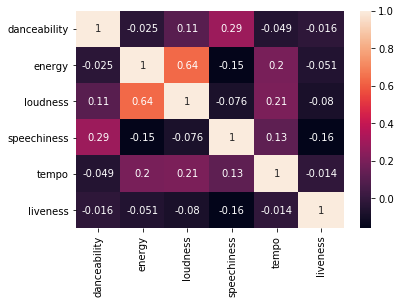

In [9]:
sns.heatmap(all_tracks.corr(), annot=True)

In [10]:
all_tracks.columns

Index(['artist', 'track', 'album', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'instrumentalness', 'tempo',
       'liveness', 'duration_ms'],
      dtype='object')

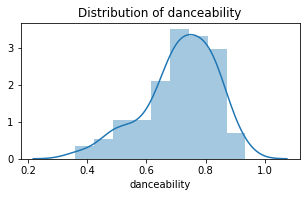

Skewness of danceability: -0.7659141561661502
Kurtosis of danceability: 0.30827326821264256



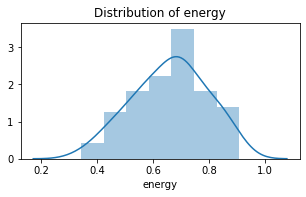

Skewness of energy: -0.21735303925945565
Kurtosis of energy: -0.5460579933822447



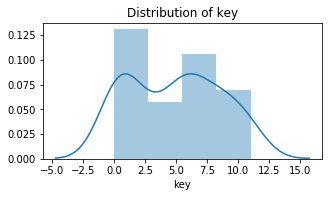

Skewness of key: 0.09544619411020762
Kurtosis of key: -1.285804454126289



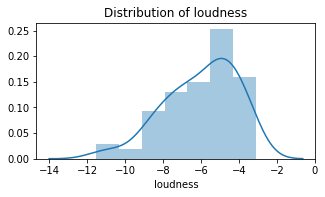

Skewness of loudness: -0.6579406957058141
Kurtosis of loudness: -0.03493192824880653



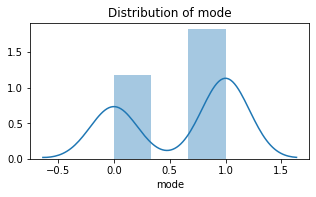

Skewness of mode: -0.4445696242060834
Kurtosis of mode: -1.8443247921996913



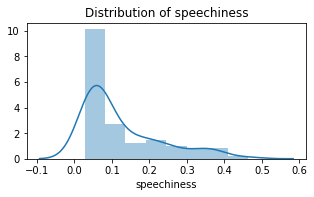

Skewness of speechiness: 1.3743013818605216
Kurtosis of speechiness: 0.999942395839216



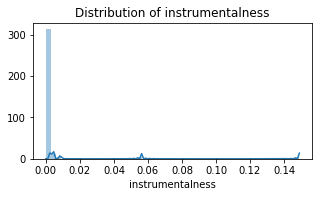

Skewness of instrumentalness: 8.033549082699246
Kurtosis of instrumentalness: 67.87089709744629



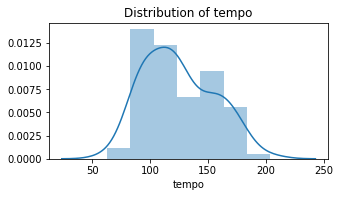

Skewness of tempo: 0.4045889716664478
Kurtosis of tempo: -0.659579024056757



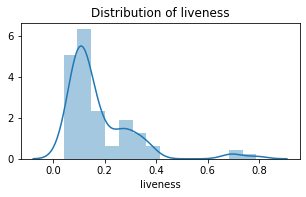

Skewness of liveness: 2.4842174071786207
Kurtosis of liveness: 7.658397285215688



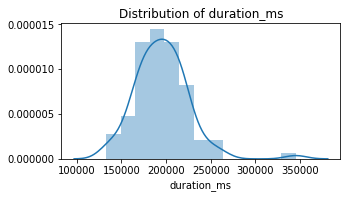

Skewness of duration_ms: 1.2705114044241312
Kurtosis of duration_ms: 5.462547589260687



In [11]:
for column in all_tracks.columns[4:]:
    
    fig, ax = plt.subplots(figsize=(5, 2.5))
    sns.distplot(all_tracks[column])
    plt.title('Distribution of {}'.format(column))
    
    plt.show()
    
    print ("Skewness of {}: ".format(column) + str(all_tracks[column].skew()))
    print ("Kurtosis of {}: ".format(column) + str(all_tracks[column].kurtosis()) + "\n")

In [12]:
X = all_tracks[all_tracks.columns[4:]]
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pC = pca.fit_transform(X)

pDF = pd.DataFrame(data=pC, columns=['principal component 1', 'principal component 2'])

pDF

,principal component 1,principal component 2
0,1.543188,1.467817
1,-0.174081,0.131774
2,-0.437913,0.085218
3,0.361056,1.652636
4,1.245755,-0.448054
...,...,...
84,-1.533690,1.198918
85,-0.156175,-1.030531
86,0.672725,0.030122
87,1.861323,-1.227605


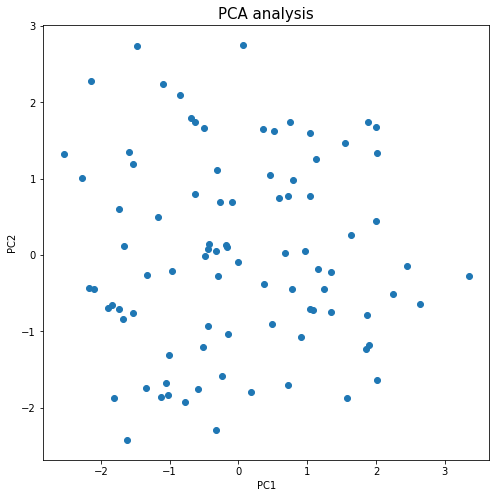

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_title('PCA analysis', fontsize=15)

ax.scatter(pDF['principal component 1'], pDF['principal component 2'])

In [14]:
dbs = DBSCAN(min_samples=6)

dbs.fit(pDF[['principal component 1', 'principal component 2']])

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=6, n_jobs=None, p=None)

In [15]:
pDF['dbscan label'] = np.array(dbs.labels_)

pDF = pDF[pDF['dbscan label'] != -1]
labels = pDF['dbscan label']

pDF

,principal component 1,principal component 2,dbscan label
1,-0.174081,0.131774,0
2,-0.437913,0.085218,0
4,1.245755,-0.448054,1
5,0.790321,0.987538,2
9,0.719960,0.780112,2
11,-0.163999,0.109288,0
12,-1.020895,-1.830875,3
16,-0.772885,-1.924290,3
21,-0.586377,-1.761534,3
24,-1.340117,-1.742137,3


In [16]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("\nClusters discovered: %d" % n_clusters_)


Clusters discovered: 5


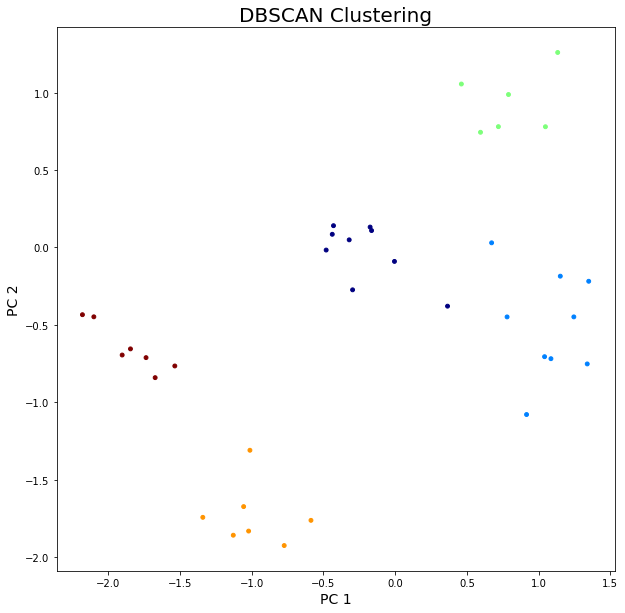

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(pDF['principal component 1'], pDF['principal component 2'], 
            c=pDF['dbscan label'], s=15, cmap='jet')

plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('PC 1',fontsize=14)
plt.ylabel('PC 2',fontsize=14)

plt.show()

In [18]:
result = pd.concat([pDF, all_tracks[all_tracks.columns[:4]]], axis=1)

result

,principal component 1,principal component 2,dbscan label,artist,track,album,id
0,NaN,NaN,NaN,Cardi B,WAP (feat. Megan Thee Stallion),WAP (feat. Megan Thee Stallion),4Oun2ylbjFKMPTiaSbbCih
1,-0.174081,0.131774,0.0,Internet Money,"Lemonade (feat. Gunna, Don Toliver & NAV)",B4 The Storm,7hxHWCCAIIxFLCzvDgnQHX
2,-0.437913,0.085218,0.0,24kGoldn,Mood (feat. Iann Dior),Mood (feat. Iann Dior),3tjFYV6RSFtuktYl3ZtYcq
3,NaN,NaN,NaN,Pop Smoke,For The Night (feat. Lil Baby & DaBaby),Shoot For The Stars Aim For The Moon,0PvFJmanyNQMseIFrU708S
4,1.245755,-0.448054,1.0,Drake,Laugh Now Cry Later (feat. Lil Durk),Laugh Now Cry Later (feat. Lil Durk),2SAqBLGA283SUiwJ3xOUVI
...,...,...,...,...,...,...,...
143,NaN,NaN,NaN,Dua Lipa,Don't Start Now,Future Nostalgia,3PfIrDoz19wz7qK7tYeu62
144,NaN,NaN,NaN,Lele Pons,Se Te Nota (with Guaynaa),Se Te Nota (with Guaynaa),11EnQRgRMJwMAesfkB5pnu
147,NaN,NaN,NaN,Jerry Di,Mi Cuarto,DI LETRA,6fmQjRuo7XvRFCK2qex5hQ
148,NaN,NaN,NaN,salem ilese,Mad at Disney,Mad at Disney,7aGyRfJWtLqgJaZoG9lJhE


In [19]:
result.dropna(inplace=True)
result.drop(result.columns[:2], axis=1, inplace=True)
result.sort_values(by=['dbscan label'], ascending=True, inplace=True)

result

,dbscan label,artist,track,album,id
1,0.0,Internet Money,"Lemonade (feat. Gunna, Don Toliver & NAV)",B4 The Storm,7hxHWCCAIIxFLCzvDgnQHX
73,0.0,Clean Bandit,Tick Tock (feat. 24kGoldn),Tick Tock (feat. 24kGoldn),27u7t9d7ZQoyjsCROHuZJ3
49,0.0,BØRNS,Electric Love,Dopamine,2GiJYvgVaD2HtM8GqD9EgQ
36,0.0,SAINt JHN,Roses - Imanbek Remix,Roses (Imanbek Remix),2Wo6QQD1KMDWeFkkjLqwx5
11,0.0,Machine Gun Kelly,my ex's best friend (with blackbear),Tickets To My Downfall,7kDUspsoYfLkWnZR7qwHZl
88,0.0,Becky Hill,Heaven On My Mind (with Sigala),Heaven On My Mind (with Sigala),7bIq1v8svANsAys7I694Up
2,0.0,24kGoldn,Mood (feat. Iann Dior),Mood (feat. Iann Dior),3tjFYV6RSFtuktYl3ZtYcq
39,1.0,Money Man,24 (feat. Lil Baby),Epidemic (Deluxe),0xUvi7wldroBzaZCengPa5
4,1.0,Drake,Laugh Now Cry Later (feat. Lil Durk),Laugh Now Cry Later (feat. Lil Durk),2SAqBLGA283SUiwJ3xOUVI
26,1.0,Gunna,DOLLAZ ON MY HEAD (feat. Young Thug),WUNNA,3nS9a01VvXHQriLqJYwRqG


In [20]:
output = result
output['dbscan label'] = result['dbscan label'].apply(lambda x: int(x+1))

output

,dbscan label,artist,track,album,id
1,1,Internet Money,"Lemonade (feat. Gunna, Don Toliver & NAV)",B4 The Storm,7hxHWCCAIIxFLCzvDgnQHX
73,1,Clean Bandit,Tick Tock (feat. 24kGoldn),Tick Tock (feat. 24kGoldn),27u7t9d7ZQoyjsCROHuZJ3
49,1,BØRNS,Electric Love,Dopamine,2GiJYvgVaD2HtM8GqD9EgQ
36,1,SAINt JHN,Roses - Imanbek Remix,Roses (Imanbek Remix),2Wo6QQD1KMDWeFkkjLqwx5
11,1,Machine Gun Kelly,my ex's best friend (with blackbear),Tickets To My Downfall,7kDUspsoYfLkWnZR7qwHZl
88,1,Becky Hill,Heaven On My Mind (with Sigala),Heaven On My Mind (with Sigala),7bIq1v8svANsAys7I694Up
2,1,24kGoldn,Mood (feat. Iann Dior),Mood (feat. Iann Dior),3tjFYV6RSFtuktYl3ZtYcq
39,2,Money Man,24 (feat. Lil Baby),Epidemic (Deluxe),0xUvi7wldroBzaZCengPa5
4,2,Drake,Laugh Now Cry Later (feat. Lil Durk),Laugh Now Cry Later (feat. Lil Durk),2SAqBLGA283SUiwJ3xOUVI
26,2,Gunna,DOLLAZ ON MY HEAD (feat. Young Thug),WUNNA,3nS9a01VvXHQriLqJYwRqG


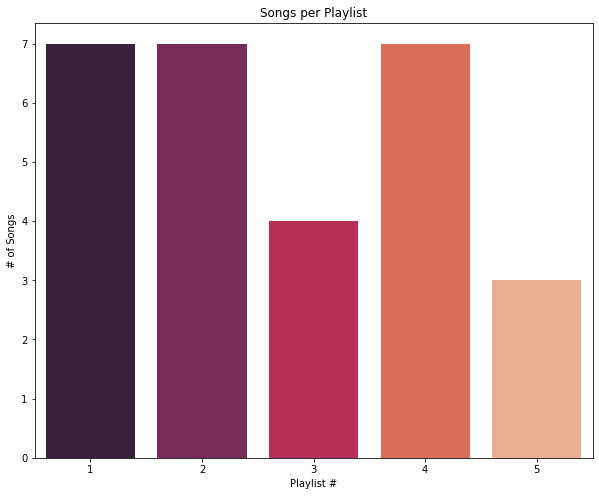

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(output['dbscan label'].value_counts().index, output['dbscan label'].value_counts(), palette="rocket")

plt.title("Songs per Playlist")
plt.xlabel("Playlist #")
plt.ylabel("# of Songs")

plt.show()